# Прогноз оттока клиентов в телеком-компании.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Оглавление:
* [1. Осмотрим данные](#1)
* [2. Предобработка и исследовательский анализ данных](#2)
* [3. Обучение моделей](#3)
* [4. Тестирование модели](#4)
* [5. Проверка модели на адекватность](#5)
* [6. Отчёт по решению ](#6)

### 1. Осмотрим данные <a class="anchor" id="1"></a>

Импортируем библиотеки:

In [1]:
# <импорт библиотеки pandas>
import pandas as pd

# <импорт библиотеки matplotlib для построения графиков>
import matplotlib.pyplot as plt

# <импорт библиотеки seaborn для построения графиков>
import seaborn as sns

# <импорт библиотеки numpy>
import numpy as np

# <импорт библиотеки math>
import math

# <код, благодаря которму графики отображаются с первого раза>
%matplotlib inline

# <код, благодаря которму датафреймы по ширине будут отображаться полностью>
pd.set_option('display.max_columns', None)

# <Отключение предупреждений>
import warnings
warnings.filterwarnings('ignore')

Прочитаем файлы, датафреймы сохраним в переменные:

In [2]:
# <Читаем файл из csv и сохраняем в переменную>
contract_info = pd.read_csv('/datasets/final_provider/contract.csv')
personal_info = pd.read_csv('/datasets/final_provider/personal.csv')
internet_info = pd.read_csv('/datasets/final_provider/internet.csv')
phone_info = pd.read_csv('/datasets/final_provider/phone.csv')

Рассмотрим информацию по датафрейму с информацией о договорах:

In [3]:
# <рассмотрим таблицу contract_info>
print(contract_info.info())
contract_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Всего в таблице 8 столбцов, типы данных у столбцов одинаковы кроме столбца *MonthlyCharges* и явно требуют преобразования.

Подробно разберём, какие в *contract_info* столбцы и какую информацию они содержат:

* *customerID* — код клиента.
* *BeginDate* — начало действия договора.
* *EndDate* — окончание действия договора, там где есть дата - это значит что клиент уже ушел.
* *Type* — тип договора, зависящий от периодичности оплаты.
* *PaperlessBilling* — безбумажная оплата или нет.
* *PaymentMethod* — способ оплаты.
* *MonthlyCharges* — размер помесячной оплаты.
* *TotalCharges* — общая сумма оплаты услуг за все время у конкретного клиента.

Важный вопрос - как создать фичу о том что клиент уже ушел/не ушел, и как после этого заполнять столбец EndDate для нынешних клиентов.

Рассмотрим информацию по датафрейму с информацией о персональных данных клиента:

In [4]:
# <рассмотрим таблицу personal_info>
print(personal_info.info())
personal_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Всего в таблице 5 столбцов, типы данных у столбцов одинаковы кроме столбца *SeniorCitizen* и явно требуют преобразования.

Подробно разберём, какие в *personal_info* столбцы и какую информацию они содержат:

* *customerID* — код клиента.
* *gender* — пол клиента.
* *SeniorCitizen* — насколько я понял, это флаг о том, пожилой ли гражданин.
* *Partner* — скреплен человек узами брака или нет.
* *Dependents* — есть ли дети или нет.

Есть вопрос по сути названий столбцов, а также есть необходимость все Yes/No превратить в 0/1.

Рассмотрим информацию по датафрейму с информацией об интернет-услугах:

In [5]:
# <рассмотрим таблицу internet_info>
print(internet_info.info())
internet_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Всего в таблице 8 столбцов, типы данных у столбцов одинаковы и явно требуют преобразования.

Подробно разберём, какие в *internet_info* столбцы и какую информацию они содержат:

* *customerID* — код клиента.
* *InternetService* — тип подключения, *DSL* или оптоволконный кабель.
* *OnlineSecurity* — наличие блокировки небезопасных сайтов.
* *OnlineBackup* — наличие облака.
* *DeviceProtection* — наличие антивируса.
* *TechSupport* — наличие выделенной линии технической поддержки.
* *StreamingTV* — наличие стримингового телевидения.
* *StreamingMovies* — наличие каталога фильмов.

Есть необходимость все столбцы кроме кода клиента превратить в 0/1.

Рассмотрим информацию по датафрейму с информацией об услугах телефонии:

In [6]:
# <рассмотрим таблицу phone_info>
print(phone_info.info())
phone_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Всего в таблице 2 столбца, типы данных у столбцов одинаковы.

Подробно разберём, какие в *phone_info* столбцы и какую информацию они содержат:

* *customerID* — код клиента.
* *MultipleLines* —  наличие услуги подключения телефонного аппарата к нескольким линиям одновременно.

Есть необходимость превратить в 0/1 столбец *MultipleLines*.

### Вывод

* В следующем пункте смерджим все датафреймы.
* Необходимо избавиться от дат.
* *PaperlessBilling*, *PaymentMethod*, *gender* выглядят бесполезными фичами. Но тот же способ оплаты может быть слишком устаревшим, а клиент может быть и не в курсе новых методов. Это значит что если этот показатель сильно влияет на уход, то имеет смысл продумать рассылку, которая уведомит клиента о новых удобствах.
* В таблице об интернет-услугах имеет смысл проанализировать уходят ли клиента из-за того что сидят более старом *DSL*.
* Таблица о телефонии на мой взгляд имеет одно из самых минимальных влияний на отток клиентов.

### 2. Предобработка и исследовательский анализ данных. <a class="anchor" id="2"></a>

Рассмотрим таблицу с договорами и проверим в ней количество полных дубликатов:

In [7]:
ci = contract_info.copy()
# <проверим количество полных дубликатов>
ci.duplicated().sum()

0

Создадим признак "срок жизни клиента".

In [8]:
# <создадим столбец с датой выгрузки данных>
ci.insert(0,'now','2020-02-01')
# <сменим ему тип>
ci['now'] = pd.to_datetime(ci['now'], errors='coerce')
# <сменим тип данных дате начала пользования услуг клиентом>
ci['BeginDate'] = ci['BeginDate'].astype("datetime64")
# <сменим все No на дату выгрузки данных>
ci['EndDate'] = (np.where((ci.EndDate == 'No'), ci['now'][0], ci.EndDate))
# <сменим тип данных дате окончания пользования услуг клиентом>
ci['EndDate'] = pd.to_datetime(ci['EndDate'], errors='coerce')
# <вычислим срок жизни клиента, используя целевой признак>
ci['Term'] = (ci['EndDate'] - ci['BeginDate']).dt.days

Сделаем целевой признак бинарным.

In [9]:
# <преобразуем EndDate в строку, чтобы было проще его преобразовать в 0/1>
ci['EndDate'] = ci['EndDate'].dt.strftime('%Y-%m-%d')
# <преобразовываем и меняем тип>
ci['EndDate'] = (np.where((ci.EndDate == '2020-02-01'), 0, ci.EndDate))
ci['EndDate'] = (np.where((ci.EndDate != 0), 1, ci.EndDate))
ci['EndDate'] = ci['EndDate'].astype("int8")

Также вычислим срок через суммы оплаты, чтобы затем сравнить значимость по-разному вычисленных сроков.

In [10]:
# <вычислим срок жизни клиента, используя регрессоры, но предварительно очистим столбец суммы от некорректных данных>
ci['TotalCharges'] = pd.to_numeric(ci['TotalCharges'],errors='coerce')
ci = ci.dropna(subset=['TotalCharges']).reset_index(drop = True)
ci['Term_from_charges'] = ci['TotalCharges'] / ci['MonthlyCharges']  

Посмотрим корреляцию между двумя сроками и суммами оплат:

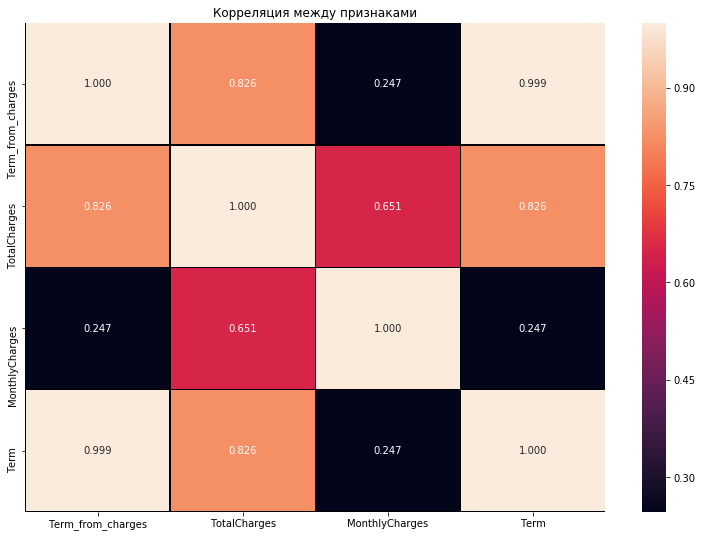

In [11]:
# <построим график, отображающий корреляцию между признаками>
plt.figure(figsize=(13,9))
sns.heatmap(ci.loc[:, ['Term_from_charges','TotalCharges','MonthlyCharges','Term']].corr(), annot=True, fmt=".3f", linewidths=.5,linecolor='black')
plt.title("Корреляция между признаками")
plt.show()

Видно что оба срока одинаково влияют на переменные, а потому мы можем спокойно удалить один из них,  и при этом использовать любой из них. Я оставлю столбец *Term*. Также видим сильную линейную связь *TotalCharges* с *MonthlyCharges* и *Term*, а потому откажемся от его использования.

In [12]:
ci = ci.drop('now', axis=1)
ci = ci.drop('BeginDate', axis=1)
ci = ci.drop('Term_from_charges', axis=1)
ci = ci.drop('TotalCharges', axis=1)

Объединим таблицы:

In [13]:
all_table = ci.merge(personal_info, on=['customerID'], how='outer')
all_table = all_table.merge(internet_info, on=['customerID'], how='outer')
all_table = all_table.merge(phone_info, on=['customerID'], how='outer')
all_table = all_table.dropna(
    subset=['MonthlyCharges']).reset_index(
    drop = True)
all_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
customerID          7032 non-null object
EndDate             7032 non-null float64
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
Term                7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     5512 non-null object
OnlineSecurity      5512 non-null object
OnlineBackup        5512 non-null object
DeviceProtection    5512 non-null object
TechSupport         5512 non-null object
StreamingTV         5512 non-null object
StreamingMovies     5512 non-null object
MultipleLines       6352 non-null object
dtypes: float64(3), int64(1), object(15)
memory usage: 1.0+ MB


Заполним пропуски в опциях интернета и телефона, будем исходить из того что если клиента не было в таблице про интернет-услуги и телефон, значит нет у него и опций. Также в столбце типа подключения тоже будет *No*.

In [14]:
all_table.fillna('No',inplace=True)
all_table['EndDate'] = all_table['EndDate'].astype("int8")
all_table['Term'] = all_table['Term'].astype("int32")
all_table['MonthlyCharges'] = all_table['MonthlyCharges'].astype("float64")
all_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
customerID          7032 non-null object
EndDate             7032 non-null int8
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
Term                7032 non-null int32
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
MultipleLines       7032 non-null object
dtypes: float64(1), int32(1), int64(1), int8(1), object(15)
memory usage: 968.4+ KB


In [15]:
# <проверим количество полных дубликатов>
all_table.duplicated().sum()

0

Поищем аномалии:

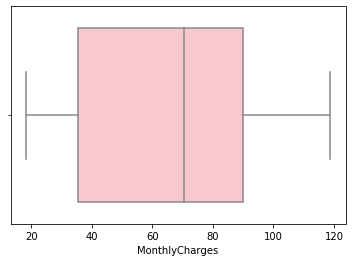

In [16]:
sns.boxplot(x="MonthlyCharges",
            palette=["pink"],
            data=all_table)

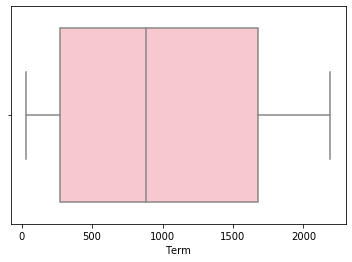

In [17]:
sns.boxplot(x="Term",
            palette=["pink"],
            data=all_table)

Значения не выходят за пределы 1.5 межквартильных размаха - все в порядке.

Первая вещь, которую захотелось проверить - зависит ли количество уходящих от периодичности оплаты договора:

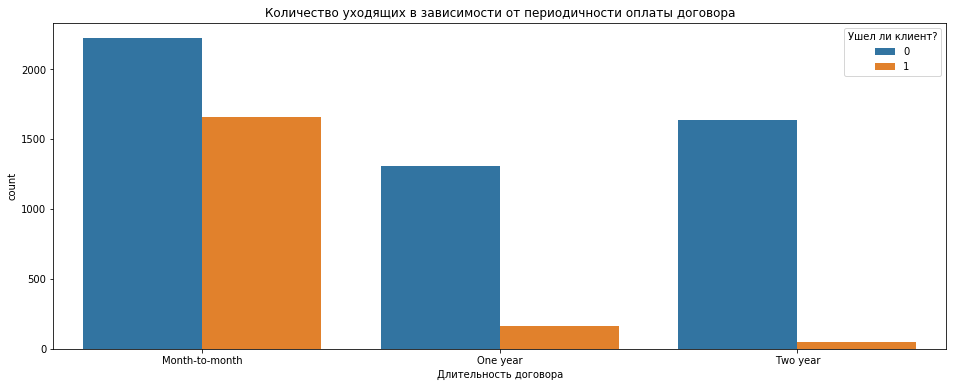

In [18]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'Type', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от периодичности оплаты договора')
plt.xlabel('Длительность договора')
plt.legend(title='Ушел ли клиент?')
plt.show()

Сразу же делаем вывод - этот признак довольно важен. Но чтобы точно удостовериться проверим с помощью критерия согласия Пирсона что частоты этого признака не случайны.

Сформулируем нулевую и альтернативную гипотезы:

**H₀:** Количество ушедших клиентов не отличается от оставшихся клиентов по разным типам договоров.

**H₁:**  Количество ушедших клиентов отличается от оставшихся клиентов по разным типам договоров.

In [19]:
# <импортируем критерий хи-квадрат>
from scipy.stats import chisquare

In [20]:
# <Метод библиотеки scipy, позволяющий проверить гипотезу>
results = chisquare(all_table[all_table['EndDate']==1]['Type'].value_counts(),all_table[all_table['EndDate']==0]['Type'].value_counts())

print('Значение критерия:', results.statistic)

if (results.statistic > 9.2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Значение критерия: 2677.3924419566256
Отвергаем нулевую гипотезу


<img src="http://mathprofi.ru/files/u/xi2.jpg" width=400 height=400 />

Договор действительно сильно влияет на вероятность ухода.

Построим распределения длительности пользования услугами для нынешних и ушедших клиентов.

Text(0.5, 1.0, 'Нынешний клиент')

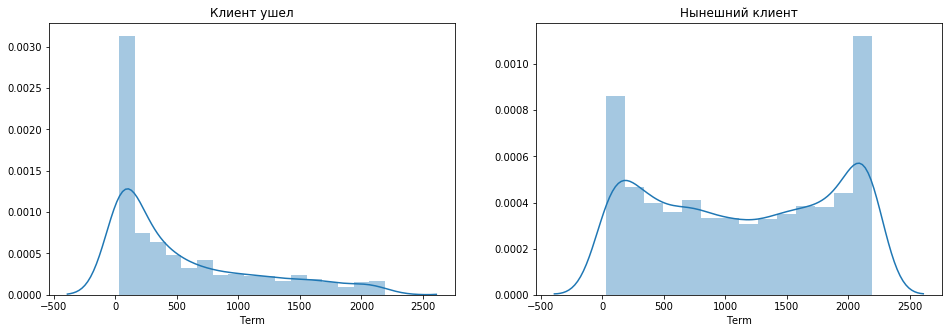

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.distplot(all_table[all_table['EndDate'] == 1]['Term'], ax = ax1).set_title('Клиент ушел')
sns.distplot(all_table[all_table['EndDate'] == 0]['Term'], ax = ax2).set_title('Нынешний клиент')

Большинство клиентов уходит в первый год, их нужно удерживать.

Построим распределения месячной оплаты для нынешних и ушедших клиентов.

Text(0.5, 1.0, 'Нынешний клиент')

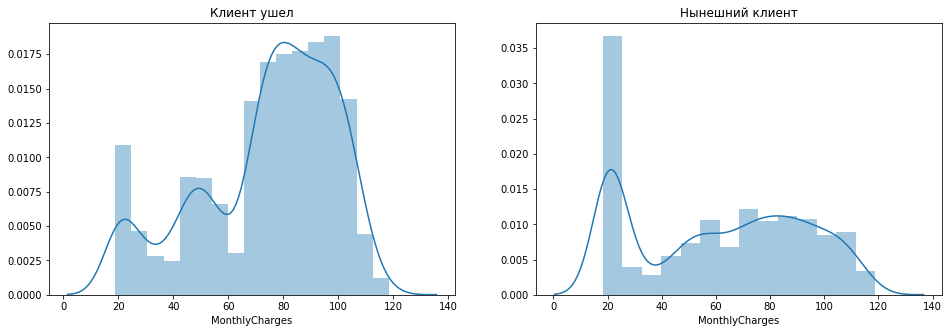

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.distplot(all_table[all_table['EndDate'] == 1]['MonthlyCharges'], ax = ax1).set_title('Клиент ушел')
sns.distplot(all_table[all_table['EndDate'] == 0]['MonthlyCharges'], ax = ax2).set_title('Нынешний клиент')

Клиенты которые уходили чаще всего имели большую стоимость месячной оплаты. Тут тоже есть работа для отдела маркетинга. Это важный признак.

Посмотрим зависимость ухода от способа оплаты:

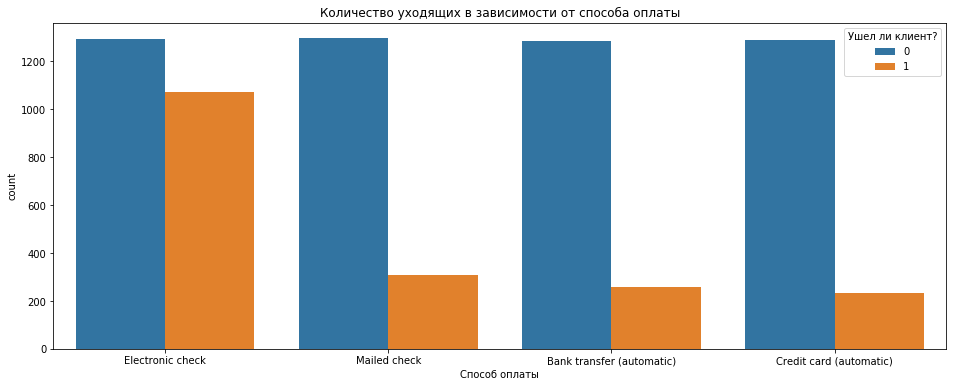

In [23]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'PaymentMethod', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от способа оплаты')
plt.xlabel('Способ оплаты')
plt.legend(title='Ушел ли клиент?')
plt.show()

Более новый способ оплаты позволяет сохранять клиентов. Но очень вероятно что уходят как раз те клиенты, которые не особо стремятся за новыми технологиями. Но очевидно стоит уведомить клиентов о способах оплаты в интернете. Признак выглядит не лишним.

Посмотрим зависимость ухода от наличия электронного чека:

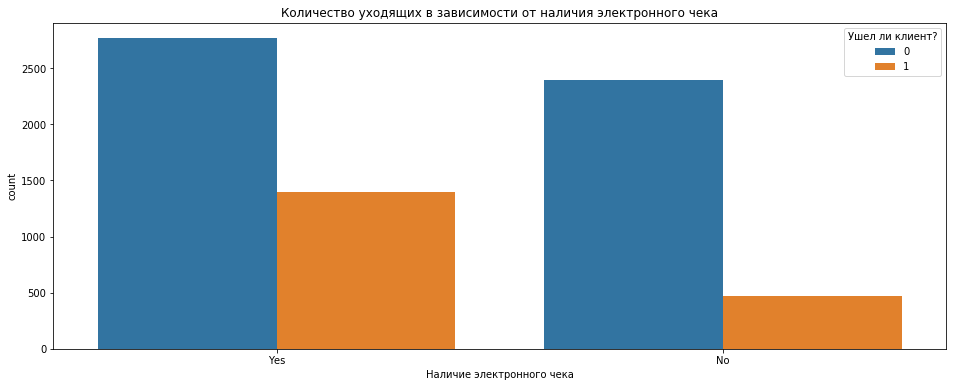

In [24]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'PaperlessBilling', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия электронного чека')
plt.xlabel('Наличие электронного чека')
plt.legend(title='Ушел ли клиент?')
plt.show()

Признак похож на предыдущий. Выглядит важным.

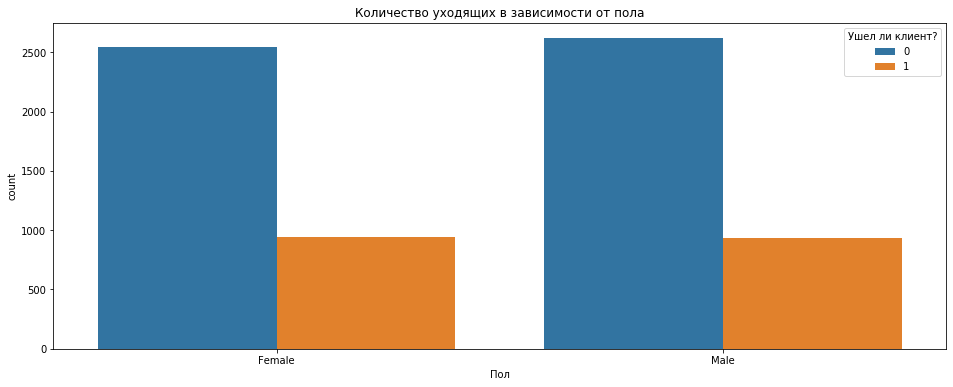

In [25]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'gender', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от пола')
plt.xlabel('Пол')
plt.legend(title='Ушел ли клиент?')
plt.show()

Пол не влияет.

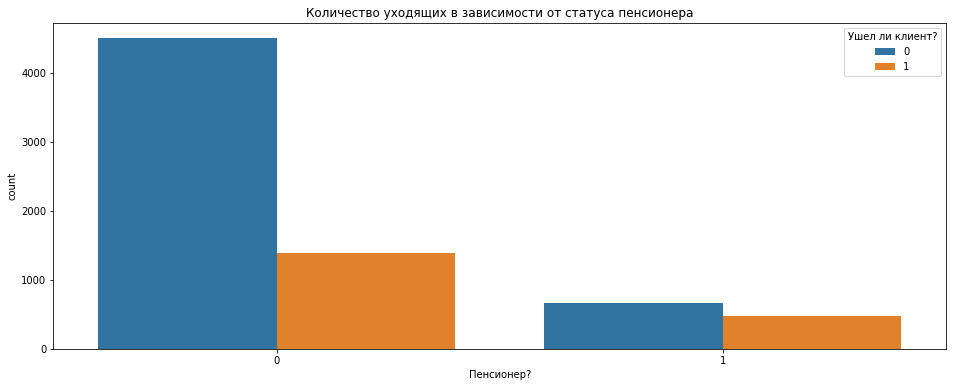

In [26]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'SeniorCitizen', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от статуса пенсионера')
plt.xlabel('Пенсионер?')
plt.legend(title='Ушел ли клиент?')
plt.show()

Если смотреть только пенсионеров, количество ушедших примерно равно нынешним. Для не пенсионеров разница гораздо выше. Этот признак значим.

Проверим признаки: *Dependents*, *Partner*.

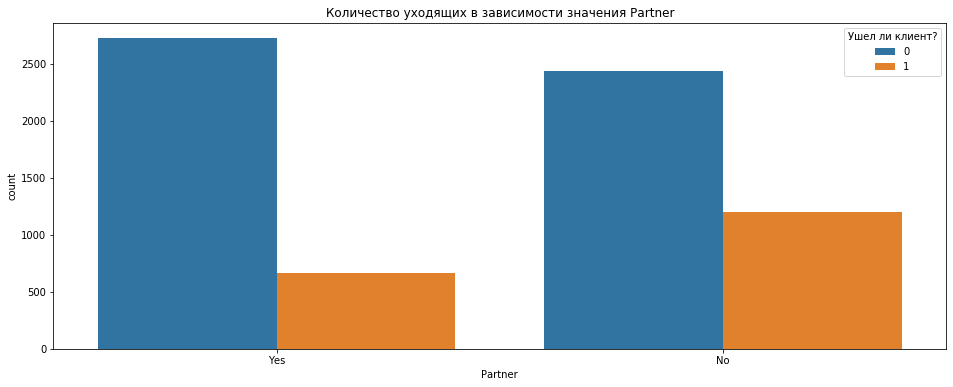

In [27]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'Partner', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости значения Partner')
plt.xlabel('Partner')
plt.legend(title='Ушел ли клиент?')
plt.show()

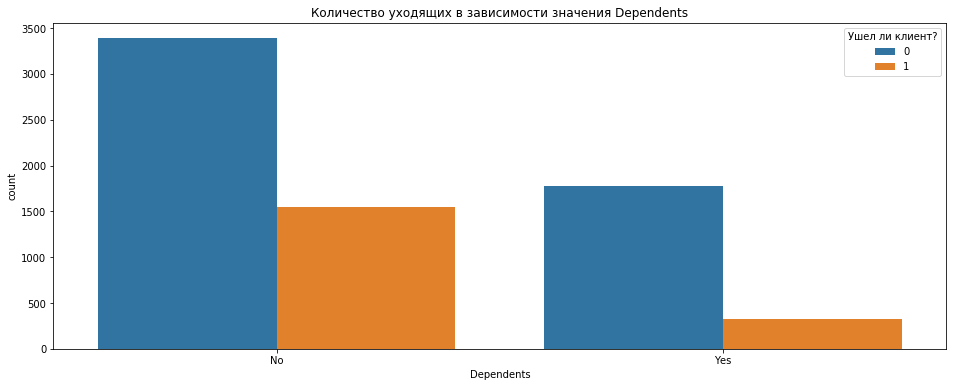

In [28]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'Dependents', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости значения Dependents')
plt.xlabel('Dependents')
plt.legend(title='Ушел ли клиент?')
plt.show()

Оба признака относительно значимы.

Тут я создавал из двух предыдущих признак "Семья". Но он оказался очень незначительным. И я добавлять его не буду.

Начнем исследовать признаки интернет-услуг:

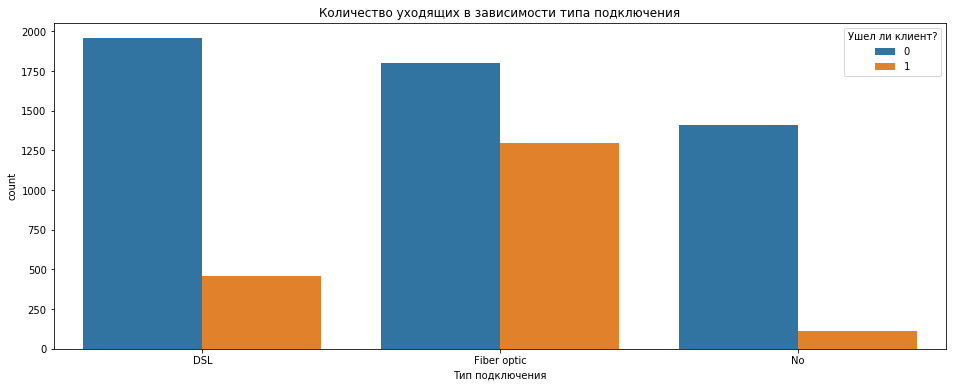

In [29]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'InternetService', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости типа подключения')
plt.xlabel('Тип подключения')
plt.legend(title='Ушел ли клиент?')
plt.show()

Моя гипотеза не подтвердилась. Есть новая - клиенты ожидавшие гиперскорость на оптоволоконном кабеле ее не получили, и решили уйти. Признак важный.

Чутье подсказывает что дополнительные услгуи имеют слабое влияние. Проверим пару выборочно.

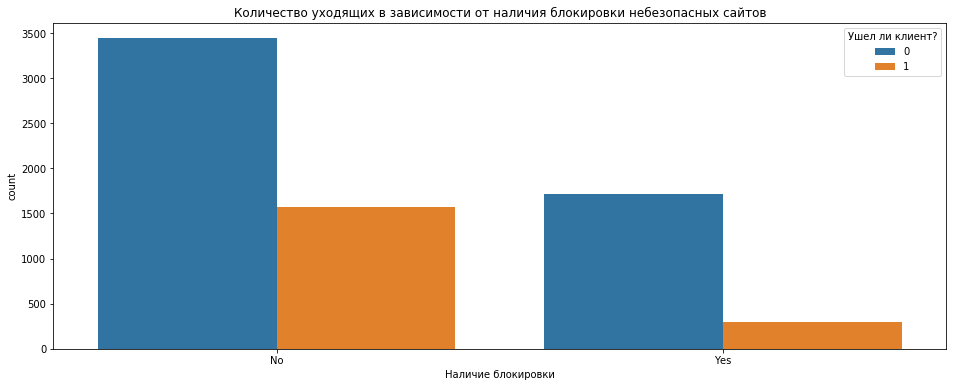

In [30]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'OnlineSecurity', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия блокировки небезопасных сайтов')
plt.xlabel('Наличие блокировки')
plt.legend(title='Ушел ли клиент?')
plt.show()

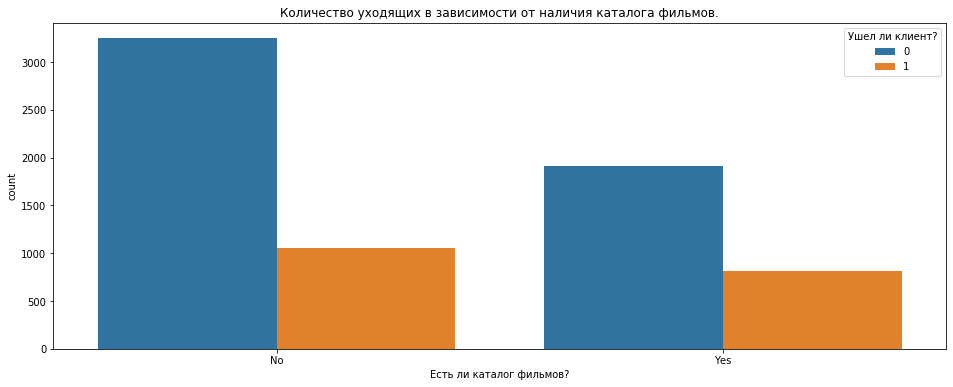

In [31]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'StreamingMovies', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия каталога фильмов.')
plt.xlabel('Есть ли каталог фильмов?')
plt.legend(title='Ушел ли клиент?')
plt.show()

Все-таки некоторые влияют. Посмотрим остальные.

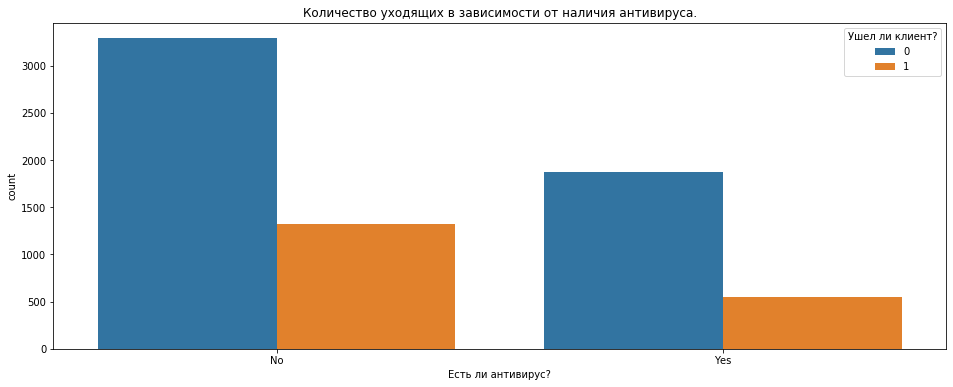

In [32]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'DeviceProtection', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия антивируса.')
plt.xlabel('Есть ли антивирус?')
plt.legend(title='Ушел ли клиент?')
plt.show()

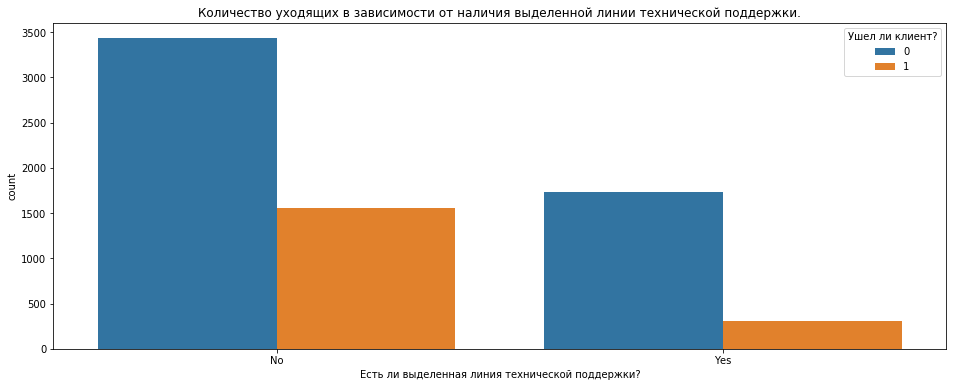

In [33]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'TechSupport', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия выделенной линии технической поддержки.')
plt.xlabel('Есть ли выделенная линия технической поддержки?')
plt.legend(title='Ушел ли клиент?')
plt.show()

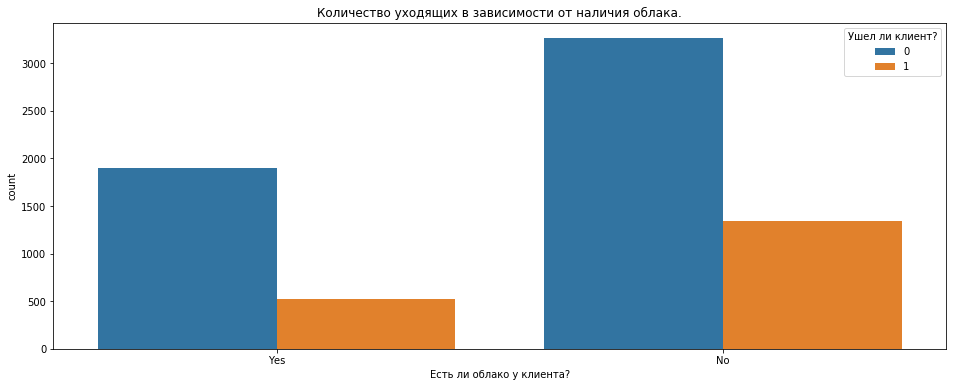

In [34]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'OnlineBackup', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия облака.')
plt.xlabel('Есть ли облако у клиента?')
plt.legend(title='Ушел ли клиент?')
plt.show()

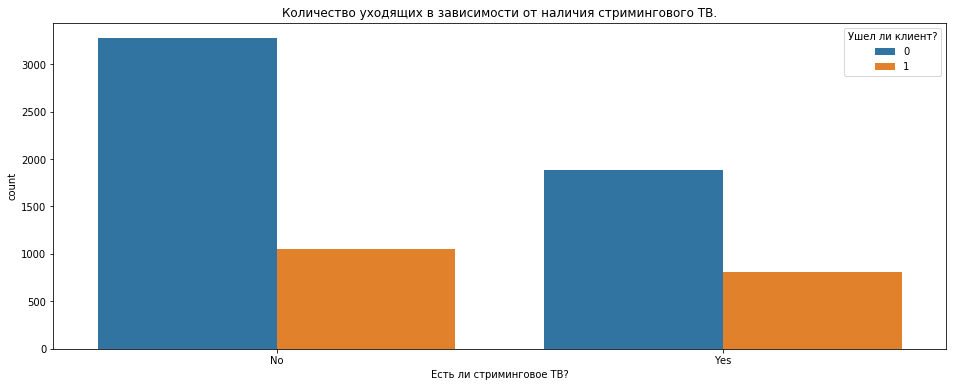

In [35]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'StreamingTV', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия стримингового ТВ.')
plt.xlabel('Есть ли стриминговое ТВ?')
plt.legend(title='Ушел ли клиент?')
plt.show()

*OnlineSecurity*, *OnlineBackup*, *DeviceProtection*, *TechSupport* выглядят важными признаками.

Единственный признак для услуги телефона:

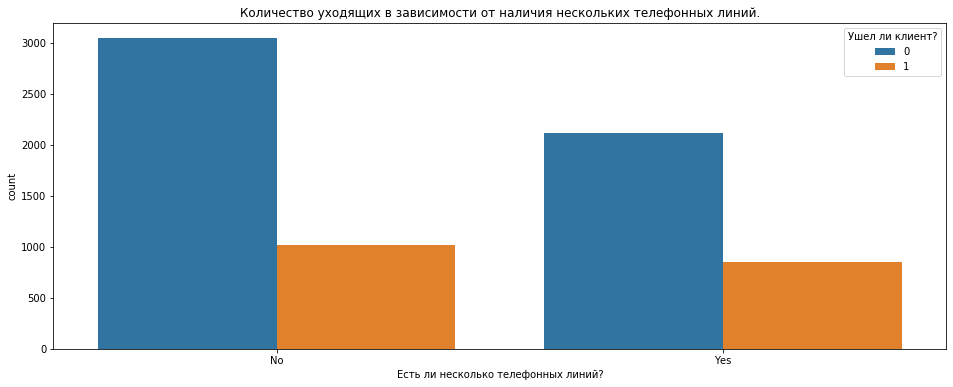

In [36]:
plt.figure(figsize=(16, 6))
g = sns.countplot(x = 'MultipleLines', hue= 'EndDate', data = all_table)
plt.title('Количество уходящих в зависимости от наличия нескольких телефонных линий.')
plt.xlabel('Есть ли несколько телефонных линий?')
plt.legend(title='Ушел ли клиент?')
plt.show()

Моя гипотеза подтвердилась, этот признак не особо важен.

Закодируем столбцы с *Yes* и *No*.

In [37]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
encoder.fit(all_table)
data_ordinal = pd.DataFrame(encoder.transform(all_table), 
                                                      columns=all_table.columns)

In [38]:
all_table['PaperlessBilling'] = data_ordinal['PaperlessBilling'].astype("int8")
all_table['Partner'] = data_ordinal['Partner'].astype("int8")
all_table['Dependents'] = data_ordinal['Dependents'].astype("int8")
all_table['OnlineSecurity'] = data_ordinal['OnlineSecurity'].astype("int8")
all_table['OnlineBackup'] = data_ordinal['OnlineBackup'].astype("int8")
all_table['DeviceProtection'] = data_ordinal['DeviceProtection'].astype("int8")
all_table['TechSupport'] = data_ordinal['TechSupport'].astype("int8")
all_table['StreamingTV'] = data_ordinal['StreamingTV'].astype("int8")
all_table['StreamingMovies'] = data_ordinal['StreamingMovies'].astype("int8")
all_table['MultipleLines'] = data_ordinal['MultipleLines'].astype("int8")
all_table.head()

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Term,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,0,Month-to-month,1,Electronic check,29.85,31,Female,0,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,0,One year,0,Mailed check,56.95,1036,Male,0,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,1,Month-to-month,1,Mailed check,53.85,61,Male,0,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,0,One year,0,Bank transfer (automatic),42.30,1371,Male,0,0,0,DSL,1,0,1,1,0,0,0
4,9237-HQITU,1,Month-to-month,1,Electronic check,70.70,61,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0


Удалим столбец с уникальным кодом клиента:

In [39]:
all_table = all_table.drop('customerID', axis=1)

Закодируем остальные столбцы техникой *OHE*:

In [40]:
data_ohe = pd.get_dummies(all_table, drop_first=True)

In [41]:
data_ohe

,EndDate,PaperlessBilling,MonthlyCharges,Term,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No
0,0,1,29.85,31,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,56.95,1036,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0
2,1,1,53.85,61,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0
3,0,0,42.30,1371,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0
4,1,1,70.70,61,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,1,84.80,730,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,1,0,0
7028,0,1,103.20,2191,0,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,0
7029,0,1,29.60,337,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7030,1,1,74.40,123,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0


### Вывод

* Пропуски убраны, дубликатов нет.
* Добавлены новые фичи, закодированы категориальные признаки.
* Самые важные признаки - срок пользования услугами клиента и тип договора.
* Что удивительно дополнительные услуги интернета тоже довольно значимы.
* Можем приступать к обучению моделей.

### 3. Обучение моделей <a class="anchor" id="3"></a>

Исследуем баланс классов:

In [42]:
# <Импортируем функцию из бибилиотеки sklearn>
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_ohe, test_size=0.2, random_state=12345)

0    4139
1    1486
Name: EndDate, dtype: int64


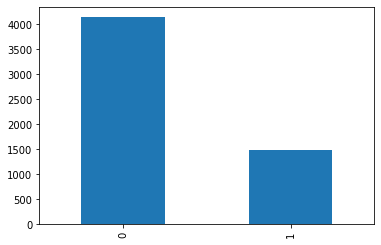

In [43]:
class_frequency = train['EndDate'].value_counts()
print(class_frequency)
class_frequency.plot(kind='bar')

Имеет смысл провести апсэмплинг миноритарного класса.

In [44]:
from sklearn.utils import resample

In [45]:
train_majority = train[train.EndDate==0]
train_minority = train[train.EndDate==1]
 
# <апсэмплинг минорного класса>
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=4139,     
                                 random_state=123) 
 
# <соединим минорный класс с мажоритарным>
train_upsampled = pd.concat([train_minority_upsampled, train_majority])

train_upsampled.EndDate.value_counts()

1    4139
0    4139
Name: EndDate, dtype: int64

Выделим признаки и целевой признак в обучающей и тестовой выборке.

In [46]:
target_train = train_upsampled['EndDate']
features_train = train_upsampled.drop('EndDate', axis=1)
target_test = test['EndDate']
features_test = test.drop('EndDate', axis=1)

Проведем масштабирование признаков:

In [47]:
# <импортируем StandardScaler из библиотеки sklearn>
from sklearn.preprocessing import StandardScaler

# <конкретизируем какие признаки будем масшатбировать>
numeric = [ 'MonthlyCharges', 'Term']

# <Проведем масштабирование features_train>
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Выведем значимости признаков:

Feature ranking:
1. feature 2 (0.205058)
2. feature 1 (0.151052)
3. feature 14 (0.072131)
4. feature 19 (0.058971)
5. feature 16 (0.047546)
6. feature 13 (0.042258)
7. feature 18 (0.038173)
8. feature 6 (0.035046)
9. feature 0 (0.034603)
10. feature 4 (0.031706)
11. feature 7 (0.030372)
12. feature 9 (0.030180)
13. feature 5 (0.027600)
14. feature 12 (0.027354)
15. feature 20 (0.026845)
16. feature 8 (0.026768)
17. feature 11 (0.026575)
18. feature 3 (0.026260)
19. feature 10 (0.025416)
20. feature 15 (0.019977)
21. feature 17 (0.016109)


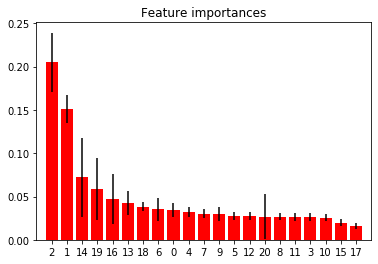

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(features_train, target_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


print("Feature ranking:")

for f in range(features_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(features_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(features_train.shape[1]), indices)
plt.xlim([-1, features_train.shape[1]])
plt.show()

Удаление признаков только ухудшало модели, а потому я оставил эти эксперименты.

Обучим логистическую регрессию:

In [67]:
# <Импортируем метод логистической регрессии>
from sklearn.linear_model import LogisticRegression
# <Импортируем функцию cross_val_score>
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [65]:
# <Создадим модель лог. регрессии,>
model_lr = LogisticRegression(random_state=645)

# <Оценим качество модели, обученной в ходе перекрестной проверки>
score = cross_val_score(model_lr,features_train, target_train,cv=4,scoring='roc_auc').mean()
accuracy_score_1 = cross_val_score(model_lr,features_train, target_train,cv=4,scoring='accuracy').mean()
recall_1 = cross_val_score(model_lr,features_train, target_train,cv=4,scoring='recall').mean()
precision_1 = cross_val_score(model_lr,features_train, target_train,cv=4,scoring='precision').mean()
# <обучаем модель> 
model_lr.fit(features_train, target_train)

# <выведем долю правильных ответов>
print('roc_auc:','{:.3f}'.format(score))
print('accuracy:','{:.3f}'.format(accuracy_score_1))
print('Полнота:','{:.3f}'.format(recall_1))
print('Точность:','{:.3f}'.format(precision_1))

roc_auc: 0.846
accuracy: 0.767
Полнота: 0.793
Точность: 0.753


Обучим RNN с долгой краткосрочной памятью. К сожалению она не дала результат который я хотел, но я очень сильно заинтересовался тем как заставить ее работать. Буду искать информацию.

In [53]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow

In [54]:
model = Sequential()

features_train_1 = features_train.values.reshape((8278,1,21))
target_train_1 = target_train.values.reshape((8278,1))
x_train, x_valid, y_train, y_valid = train_test_split(features_train_1,target_train_1, test_size=0.25, shuffle= True)

# Добавим слой LSTM
model.add(LSTM(5,input_shape=(1,21),return_sequences = True,activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(5,input_shape=(1,21),activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 5)              540       
_________________________________________________________________
dropout (Dropout)            (None, 1, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 766
Trainable params: 766
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.fit(x_train,y_train,verbose=2,epochs=30,validation_data=(x_valid,y_valid),batch_size=64)

Train on 6208 samples, validate on 2070 samples
Epoch 1/30
6208/6208 - 4s - loss: 0.6928 - accuracy: 0.5119 - val_loss: 0.6897 - val_accuracy: 0.6396
Epoch 2/30
6208/6208 - 1s - loss: 0.6548 - accuracy: 0.6666 - val_loss: 0.5850 - val_accuracy: 0.7193
Epoch 3/30
6208/6208 - 1s - loss: 0.5448 - accuracy: 0.7321 - val_loss: 0.5279 - val_accuracy: 0.7329
Epoch 4/30
6208/6208 - 1s - loss: 0.5170 - accuracy: 0.7592 - val_loss: 0.5177 - val_accuracy: 0.7372
Epoch 5/30
6208/6208 - 1s - loss: 0.5071 - accuracy: 0.7572 - val_loss: 0.5109 - val_accuracy: 0.7415
Epoch 6/30
6208/6208 - 1s - loss: 0.5050 - accuracy: 0.7606 - val_loss: 0.5074 - val_accuracy: 0.7440
Epoch 7/30
6208/6208 - 1s - loss: 0.5033 - accuracy: 0.7627 - val_loss: 0.5062 - val_accuracy: 0.7401
Epoch 8/30
6208/6208 - 1s - loss: 0.5034 - accuracy: 0.7661 - val_loss: 0.5044 - val_accuracy: 0.7459
Epoch 9/30
6208/6208 - 1s - loss: 0.5009 - accuracy: 0.7640 - val_loss: 0.5034 - val_accuracy: 0.7464
Epoch 10/30
6208/6208 - 1s - loss:

Выведем ROC-AUC:

In [102]:
probabilities_valid = model.predict_proba(features_train_1)
auc_roc = roc_auc_score(target_train,probabilities_valid)    
print('roc_auc:','{:.3f}'.format(auc_roc))
print('Полнота:','{:.3f}'.format(recall_score(target_train,pd.Series(model.predict_classes(features_train_1).reshape(8278)))))
print('Точность:','{:.3f}'.format(precision_score(target_train,pd.Series(model.predict_classes(features_train_1).reshape(8278)))))

roc_auc: 0.854
Полнота: 0.801
Точность: 0.752


Попробуем использовать библиотеку *LightGBM* и ее *Dropouts meet Multiple Additive Regression Trees*:

In [61]:
import lightgbm as lgb

In [62]:
%%time
hyper_params = {
    'learning_rate': 0.13,
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'binary',
    "num_iterations": 190,
    'max_depth': 10,
    'num_leaves': 75
}
dart = lgb.LGBMClassifier(**hyper_params)
dart.fit(features_train, target_train,
        eval_set=[(features_train, target_train)],
        eval_metric='auc',
        early_stopping_rounds=10, verbose = 10)

[10]	training's auc: 0.928287	training's binary_logloss: 0.425605
[20]	training's auc: 0.948693	training's binary_logloss: 0.337861
[30]	training's auc: 0.959317	training's binary_logloss: 0.300105
[40]	training's auc: 0.966488	training's binary_logloss: 0.280815
[50]	training's auc: 0.971123	training's binary_logloss: 0.275218
[60]	training's auc: 0.976814	training's binary_logloss: 0.258413
[70]	training's auc: 0.979521	training's binary_logloss: 0.248255
[80]	training's auc: 0.982488	training's binary_logloss: 0.236658
[90]	training's auc: 0.983302	training's binary_logloss: 0.238266
[100]	training's auc: 0.984265	training's binary_logloss: 0.230843
[110]	training's auc: 0.984458	training's binary_logloss: 0.237366
[120]	training's auc: 0.986223	training's binary_logloss: 0.221616
[130]	training's auc: 0.987081	training's binary_logloss: 0.2155
[140]	training's auc: 0.988574	training's binary_logloss: 0.209493
[150]	training's auc: 0.989353	training's binary_logloss: 0.204847
[160]	

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.13, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_iterations=190, num_leaves=75,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, task='train')

In [81]:
pred=dart.predict(features_train)
print('accuracy:','{:.3f}'.format(accuracy_score(target_train,pred)))
print('Полнота:','{:.3f}'.format(recall_score(target_train,pred)))
print('Точность:','{:.3f}'.format(precision_score(target_train,pred)))

accuracy: 0.955
Полнота: 0.981
Точность: 0.933


### Вывод

* Логистическая регрессия показала стабильный и хороший результат.
* RNN показала результат лучше, но я ожидал большего. К сожалению с нейросетями пока эксперименты не очень успешны.
* Лучший результат показала модель *DART* с градиентным бустингом.

### 4. Тестирование модели <a class="anchor" id="4"></a>

Проверим логистическую регрессию на тестовой выборке:

In [90]:
probabilities_valid = model_lr.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test,probabilities_one_valid)
pred_lr=model_lr.predict(features_test)
print('accuracy:','{:.3f}'.format(accuracy_score(target_test,pred_lr)))
print('roc_auc:','{:.3f}'.format(auc_roc))
print('Полнота:','{:.3f}'.format(recall_score(target_test,pred_lr)))
print('Точность:','{:.3f}'.format(precision_score(target_test,pred_lr)))

accuracy: 0.752
roc_auc: 0.849
Полнота: 0.783
Точность: 0.530


Проверим нейронную сеть на тестовой выборке:

In [99]:
features_test_1 = features_test.values.reshape((1407,1,21))
probabilities_valid = model.predict_proba(features_test_1)
auc_roc = roc_auc_score(target_test,probabilities_valid)    
pred_ml=model.predict_classes(features_test_1)
print('accuracy:','{:.3f}'.format(accuracy_score(target_test,pd.Series(pred_ml.reshape(1407)))))
print('roc_auc:','{:.3f}'.format(auc_roc))
print('Полнота:','{:.3f}'.format(recall_score(target_test,pd.Series(pred_ml.reshape(1407)))))
print('Точность:','{:.3f}'.format(precision_score(target_test,pd.Series(pred_ml.reshape(1407)))))

accuracy: 0.754
roc_auc: 0.846
Полнота: 0.783
Точность: 0.533


Проверим модель *DART* на тестовой выборке:

In [82]:
probabilities_valid = dart.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test,probabilities_one_valid)   
pred=dart.predict(features_test)
print('accuracy:','{:.3f}'.format(accuracy_score(target_test,pred)))
print('roc_auc:','{:.3f}'.format(auc_roc))
print('Полнота:','{:.3f}'.format(recall_score(target_test,pred)))
print('Точность:','{:.3f}'.format(precision_score(target_test,pred)))

accuracy: 0.833
roc_auc: 0.893
Полнота: 0.728
Точность: 0.680


Лучший результат у модели DART.

### Вывод

* Лучший результат по *accuracy* и *AUC_ROC* у *DART*.
* Но метрика полноты лучше у нейросети и логистической регресии, а это более важная для бизнеса метрика - то насколько верно модель предсказывает уход клиента.

### 5. Проверка модели на адекватность <a class="anchor" id="5"></a>

Модель которая дает положительные ответы и отрицательные с вероятностью 50 на 50:

In [95]:
import random

random_predictions = np.random.randint(low = 0, high = 2, size = 1407) 

# <подсчитаем долю правильных ответов.>
accuracy = accuracy_score(target_test, random_predictions)

random_predictions_1 = np.random.random_sample(1407) 

auc_roc = roc_auc_score(target_test,random_predictions_1)

# <выведем долю правильных ответов>
print('accuracy:','{:.4f}'.format(accuracy))
print('roc_auc:','{:.3f}'.format(auc_roc))
print('Полнота:','{:.3f}'.format(recall_score(target_test,random_predictions)))
print('Точность:','{:.3f}'.format(precision_score(target_test,random_predictions)))

accuracy: 0.4996
roc_auc: 0.501
Полнота: 0.470
Точность: 0.264


Модель которая дает всегда отрицательные ответы:

In [96]:
import random

random_predictions = np.random.randint(low = 0, high = 1, size = 1407) 

# <подсчитаем долю правильных ответов.>
accuracy = accuracy_score(target_test, random_predictions)
auc_roc = roc_auc_score(target_test,random_predictions) 
# <выведем долю правильных ответов>
print('accuracy =','{:.4f}'.format(accuracy))
print('roc_auc:','{:.3f}'.format(auc_roc))
print('Полнота:','{:.3f}'.format(recall_score(target_test,random_predictions)))
print('Точность:','{:.3f}'.format(precision_score(target_test,random_predictions)))

accuracy = 0.7278
roc_auc: 0.500
Полнота: 0.000
Точность: 0.000


Как видим такая модель недалеко ушла в плане *accuracy* от наших. Это связано с дисбалансом классов. Тем не менее экономический эффект от нашей модели гораздо выше, мы выявлем тех кто хочет уйти с большей вероятностью - и можем на них повлиять.

### Вывод

Наша модель точно лучше случайных.